# ImagePDF - wmin (Full Covmat)

In [1]:
import itertools

import numpy as np

import jax.numpy as jnp
import jax

from jax.example_libraries import optimizers

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys.commondataparser import load_commondata

from reportengine import collect

import pandas as pd
from validphys.core import DataGroupSpec

from validphys.pdfbases import evolution
from validphys import convolution
from validphys import covmats
from validphys.loader import Loader

import jax.scipy.linalg as jla



In [2]:
inp = {
    "fit": "210713-n3fit-001",
    "dataset_inputs": {"from_": "fit"},
    "use_cuts": "internal",
    "theoryid": 400
}

In [3]:
data = API.data(**inp)

In [4]:
# store grids with shape (50,) only
xx = []

excluded = set()
included = set()

for ds in data.datasets:

    for fk in ds.fkspecs:

        xgrid = load_fktable(fk).xgrid
        
        if xgrid.shape != (50,):
            print("Excluding", ds)
            excluded.add(ds)
            continue
        else:
            xx.append(xgrid)
            included.add(ds)
included = list(included)

Excluding ATLAS_1JET_8TEV_R06_DEC
Excluding ATLAS_2JET_7TEV_R06
Excluding CMS_2JET_7TEV
Excluding CMS_1JET_8TEV


In [5]:
class FilteredDataGroupSpec(DataGroupSpec):
        pass

# FilteredDataGroupSpec = namedtuple('DataGroupSpec', ('name', 'datasets'))
filtered_data = FilteredDataGroupSpec(name = "data", datasets = tuple(included), dsinputs = included)


In [6]:
arr = np.array(xx)

In [7]:
arr.std(axis=0).max()

1.3322676295501878e-15

In [8]:
# list of datasetspecs
datasets = list(filtered_data.dsinputs)

In [9]:
# TODO: Is this needed?
# jit: just-in-time (JIT) compilation decorator
# compile functions
OP = {key: jax.jit(val) for key,val in convolution.OP.items()}

In [10]:
OP

{'RATIO': <CompiledFunction of <built-in function truediv>>,
 'ASY': <CompiledFunction of <function _asy at 0x185d7e160>>,
 'ADD': <CompiledFunction of <built-in function add>>,
 'SMN': <CompiledFunction of <function _smn at 0x185d7e1f0>>,
 'COM': <CompiledFunction of <function _com at 0x185d95550>>,
 'SMT': <CompiledFunction of <function _smt at 0x185d955e0>>,
 'NULL': <CompiledFunction of <function _id at 0x185d95670>>}

In [11]:
rng = jax.random.PRNGKey(0xDEADBEEF)

In [12]:
l = Loader()
pdf = l.check_pdf("210713-n3fit-001")


# shape (101, 14, 50)
# LinearBasis Class - > implements basis transformation from flavour to any?
# grid_values: Evaluate ``x*f(x)`` on a grid of points in flavour, x and Q.

INPUT_GRID = evolution.grid_values(pdf, convolution.FK_FLAVOURS, xx[0], [1.65]).squeeze(-1)

# initial weights for weight minimization?
weight_base_num = jax.random.normal(rng, shape=(INPUT_GRID.shape[0],))
weight_base = weight_base_num/jnp.sum(weight_base_num)

LHAPDF 6.4.0 loading all 101 PDFs in set 210713-n3fit-001
210713-n3fit-001, version 1; 101 PDF members


In [13]:
pdf

PDF(name='210713-n3fit-001')

In [14]:
evolution.grid_values

<bound method Basis.grid_values of <validphys.pdfbases.LinearBasis object at 0x185d894c0>>

## Prediction Functions

In [15]:
def make_dis_prediction(fk):
    """
    TODO
    
    Parameters
    ----------
    fk : 
    
    Returns
    -------
    
    
    """
    indices = fk.luminosity_mapping
    fk_arr = jnp.array(fk.get_np_fktable())
    
    @jax.jit
    def dis_prediction(pdf):
        """
        Compute theory prediction as
        
        T_i = FK_{i,a,x} f_{a,x}
        
        summing over repeated indices
        
        Parameters
        ----------
        pdf : 
        
        """
        return jnp.einsum("ijk, jk ->i", fk_arr, pdf[indices, :])
    return dis_prediction
    
    
def make_had_prediction(fk):
    indices = fk.luminosity_mapping
    first_indices = indices[0::2]
    second_indices = indices[1::2]
    fk_arr = jnp.array(fk.get_np_fktable())
    @jax.jit
    def had_prediction(pdf):
        return jnp.einsum("ijkl,jk,jl->i", fk_arr, pdf[first_indices,:], pdf[second_indices,:])
    return had_prediction


def make_pred_dataset(dataset):
    """
    """
    
    pred_funcs = []
    
    # why does each dataset have several fkspecs?
    # e.g. compound has two fkspec?
    
    for fkspec in dataset.fkspecs:
        fk = load_fktable(fkspec).with_cuts(dataset.cuts)
        if fk.hadronic:
            pred = make_had_prediction(fk)
        else:
            pred = make_dis_prediction(fk)
        pred_funcs.append(pred)
    @jax.jit
    def prediction(pdf):
        return OP[dataset.op](*[f(pdf) for f in pred_funcs])
    
    return prediction

def make_pred_data(data):
    """
    TODO
    same as make_pred_datasets but for datagroupspec
    
    returns jnp.array
    
    """
    predictions = []
    for ds in data.datasets:
        predictions.append(make_pred_dataset(ds))

    def eval_preds(pdf):
        return jnp.array(list(itertools.chain(*[f(pdf) for f in predictions])))

    return eval_preds

In [16]:
make_pred_dataset(datasets[41])(INPUT_GRID[1]) - jnp.array(datasets[41].load_commondata().central_values)

DeviceArray([ 0.00634867,  0.00335842,  0.00362329,  0.01082769,
              0.00603989,  0.00212616,  0.00160196,  0.00900104,
             -0.00943604], dtype=float32)

In [17]:
make_pred_dataset(datasets[42])#(INPUT_GRID[0])

<CompiledFunction of <function make_pred_dataset.<locals>.prediction at 0x186d9c5e0>>

In [18]:
m_p_d = make_pred_data(filtered_data)

In [19]:
INPUT_GRID[0].shape

(14, 50)

In [20]:
m_p_d(INPUT_GRID[0])

DeviceArray([ 0.27635032,  0.27725986,  0.27277255, ..., 14.925656  ,
             11.301424  ,  4.898467  ], dtype=float32)

## Loss functions

In [42]:
def make_chi2(ds):
    """
    
    """
    cd = load_commondata(ds.commondata).with_cuts(ds.cuts)

    central_value = jnp.array(cd.central_values)

    covmat = covmats.covmat_from_systematics(cd, dataset_input=ds)

    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))

    pred = make_pred(ds)
    
    @jax.jit
    def chi2(pdf):
        diff = pred(pdf) - central_value
        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2


def make_chi2_data(data):
    """
    
    """

    cd_list = data.load_commondata_instance()

    central_values = [cd.central_values for cd in cd_list]
    
    central_values = jnp.array(pd.concat(central_values, axis=0))

    covmat = covmats.dataset_inputs_covmat_from_systematics(cd_list, data_input=data.dsinputs)
    
    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))
    
    pred = make_pred_data(data) 
    
    @jax.jit
    def chi2(pdf):
        diff = pred(pdf) - central_values

        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2

def make_chi2_data_mini_batch(data):
    """
    
    """

    cd_list = data.load_commondata_instance()

    central_values = [cd.central_values for cd in cd_list]
    
    central_values = jnp.array(pd.concat(central_values, axis=0))

    covmat = covmats.dataset_inputs_covmat_from_systematics(cd_list, data_input=data.dsinputs)
    
    sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))
    
    pred = make_pred_data(data) 
    
    @jax.jit
    def chi2(pdf,batch_idx):
        diff = pred(pdf)[batch_idx] - central_values[batch_idx]

        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat[batch_idx][:,batch_idx], diff[batch_idx], lower=True)
        return jnp.sum(chi2_vec**2)
    
    return chi2


chi2_contribs_data = make_chi2_data(filtered_data)
chi2_contribs_data_mini_batch = make_chi2_data_mini_batch(filtered_data)

@jax.jit
def loss_data(weights):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_contribs_data(pdf)



In [49]:
print(type(data))
print(len(data))
print(type(filtered_data))
print(len(filtered_data))
print(m_p_d(INPUT_GRID[0]).shape)

Ndat = m_p_d(INPUT_GRID[0]).shape[0]
# filtered_data


<class 'validphys.core.DataGroupSpec'>
77
<class '__main__.FilteredDataGroupSpec'>
73
(4116,)


In [58]:
m_p_d(INPUT_GRID[0])

DeviceArray([ 0.27635032,  0.27725986,  0.27277255, ..., 14.925656  ,
             11.301424  ,  4.898467  ], dtype=float32)

## mini batch gradient descendt

In [50]:
@jax.jit
def loss_data_batch(weights,batch_idx):
    pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
    return chi2_contribs_data_mini_batch(pdf,batch_idx)

In [59]:
# compute grad on mini batch
grad = jax.grad(loss_data_batch)(weight_base,jnp.array([0,1,2,3]))

In [60]:
grad

DeviceArray([ 0.07370774, -0.06984708,  0.2326659 ,  0.21401976,
              0.14169309,  0.24338755,  0.26339436, -0.07089938,
              0.25879586,  0.22700156,  0.21106575, -0.09053056,
             -0.05604686,  0.18920036,  0.4141542 ,  0.04981143,
              0.2398088 ,  0.01739606,  0.02950082, -0.02924328,
              0.05645839,  0.1376925 ,  0.21773429,  0.07515126,
             -0.09077772, -0.15392087,  0.00882408,  0.569267  ,
             -0.11413179,  0.06770868, -0.0955558 ,  0.18222985,
             -0.02590208,  0.13533315, -0.2090689 ,  0.05113196,
              0.24823275,  0.44652343,  0.26688057,  0.07456423,
              0.0603768 ,  0.10705925,  0.00471255,  0.3321698 ,
              0.02325457,  0.11122127,  0.16759439,  0.05920324,
              0.0203609 , -0.01021271, -0.16155577,  0.20317361,
              0.01823807,  0.03586987,  0.03987553,  0.24731207,
             -0.04371199, -0.07825259,  0.06823428,  0.14928731,
              0.1041695 ,

In [28]:
mcd = make_chi2_data(filtered_data)

In [29]:
mcd(INPUT_GRID[0])

DeviceArray(4760.2744, dtype=float32)

In [30]:

chi2_contribs_data(jnp.einsum("i,ijk",weight_base,INPUT_GRID))


DeviceArray(4854.155, dtype=float32)

In [31]:
# loss(jnp.eye(1, 1001)[0,:])
loss_data(jnp.eye(1, 101)[0,:])

DeviceArray(4760.2744, dtype=float32)

In [32]:
# loss(weight_base)
loss_data(weight_base)

DeviceArray(4854.1577, dtype=float32)

### Compute gradient

In [33]:
grad = jax.grad(loss_data)(weight_base)

In [34]:
grad.shape

(101,)

In [35]:
import random

In [63]:
optimizers?

In [36]:
#batch_size = len(datasets)

momentum_mass = 0.9

step_size = 1e-8

num_epochs = 500

#num_complete_batches, leftover = divmod(len(chi2_contribs), batch_size)
#num_batches = num_complete_batches + bool(leftover)

opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)




In [51]:
#def batch_stream():
#    state = random.Random(0)
#    while True:
#        permutation = state.sample(chi2_contribs, len(chi2_contribs))
#        for i in range(num_batches):
#            yield permutation[i*batch_size: (i+1)*batch_size]

In [37]:
@jax.jit
def update(i, opt_state, 
          # batch
          ):
    params = get_params(opt_state)
    return opt_update(i, jax.grad(loss_data)(params, 
                      #                  batch
                                       ), 
                      opt_state)

In [38]:
#batch_iter = batch_stream()
opt_counter = itertools.count()
opt_state = opt_init(weight_base)

for epoch in range(num_epochs):
    print(f"Epoch {epoch}, loss", 
          loss_data(get_params(opt_state)) 
    )
    #for _ in range(num_batches):
        #batch = next(batch_iter)
    opt_state = update(next(opt_counter), opt_state, 
                          # batch
                          )
        


Epoch 0, loss 4854.1577
Epoch 1, loss 4853.0024
Epoch 2, loss 4854.4175
Epoch 3, loss 4852.393
Epoch 4, loss 4854.2393
Epoch 5, loss 4852.252
Epoch 6, loss 4853.719
Epoch 7, loss 4852.369
Epoch 8, loss 4853.103
Epoch 9, loss 4852.551
Epoch 10, loss 4852.5234
Epoch 11, loss 4852.662
Epoch 12, loss 4852.111
Epoch 13, loss 4852.615
Epoch 14, loss 4851.877
Epoch 15, loss 4852.4297
Epoch 16, loss 4851.781
Epoch 17, loss 4852.1494
Epoch 18, loss 4851.7397
Epoch 19, loss 4851.852
Epoch 20, loss 4851.7095
Epoch 21, loss 4851.5933
Epoch 22, loss 4851.63
Epoch 23, loss 4851.3887
Epoch 24, loss 4851.5283
Epoch 25, loss 4851.239
Epoch 26, loss 4851.3525
Epoch 27, loss 4851.1206
Epoch 28, loss 4851.18
Epoch 29, loss 4851.0273
Epoch 30, loss 4850.9893
Epoch 31, loss 4850.917
Epoch 32, loss 4850.835
Epoch 33, loss 4850.8193
Epoch 34, loss 4850.6826
Epoch 35, loss 4850.672
Epoch 36, loss 4850.539
Epoch 37, loss 4850.5347
Epoch 38, loss 4850.434
Epoch 39, loss 4850.387
Epoch 40, loss 4850.302
Epoch 41,

Epoch 330, loss 4832.2407
Epoch 331, loss 4832.184
Epoch 332, loss 4832.1226
Epoch 333, loss 4832.058
Epoch 334, loss 4831.9995
Epoch 335, loss 4831.947
Epoch 336, loss 4831.8896
Epoch 337, loss 4831.8325
Epoch 338, loss 4831.776
Epoch 339, loss 4831.7085
Epoch 340, loss 4831.655
Epoch 341, loss 4831.6025
Epoch 342, loss 4831.5415
Epoch 343, loss 4831.478
Epoch 344, loss 4831.4155
Epoch 345, loss 4831.3535
Epoch 346, loss 4831.291
Epoch 347, loss 4831.2305
Epoch 348, loss 4831.177
Epoch 349, loss 4831.1187
Epoch 350, loss 4831.055
Epoch 351, loss 4830.996
Epoch 352, loss 4830.939
Epoch 353, loss 4830.882
Epoch 354, loss 4830.8213
Epoch 355, loss 4830.757
Epoch 356, loss 4830.7036
Epoch 357, loss 4830.642
Epoch 358, loss 4830.5874
Epoch 359, loss 4830.5234
Epoch 360, loss 4830.4683
Epoch 361, loss 4830.411
Epoch 362, loss 4830.344
Epoch 363, loss 4830.284
Epoch 364, loss 4830.2354
Epoch 365, loss 4830.1797
Epoch 366, loss 4830.1187
Epoch 367, loss 4830.0586
Epoch 368, loss 4830.002
Epoc

In [54]:
for epoch in range(num_epochs, 2*num_epochs):
    print(f"Epoch {epoch}, loss", 
          loss(get_params(opt_state)) 
    )
    #for _ in range(num_batches):
        #batch = next(batch_iter)
    opt_state = update(next(opt_counter), opt_state, 
                          # batch
                          
            

Epoch 500, loss 4755.4424
Epoch 501, loss 4755.387
Epoch 502, loss 4755.3296
Epoch 503, loss 4755.2793
Epoch 504, loss 4755.2354
Epoch 505, loss 4755.1865
Epoch 506, loss 4755.138
Epoch 507, loss 4755.0815
Epoch 508, loss 4755.0327
Epoch 509, loss 4754.9844
Epoch 510, loss 4754.9307
Epoch 511, loss 4754.873
Epoch 512, loss 4754.826
Epoch 513, loss 4754.7773
Epoch 514, loss 4754.73
Epoch 515, loss 4754.6733
Epoch 516, loss 4754.6304
Epoch 517, loss 4754.5728
Epoch 518, loss 4754.5225
Epoch 519, loss 4754.466
Epoch 520, loss 4754.4126
Epoch 521, loss 4754.3677
Epoch 522, loss 4754.319
Epoch 523, loss 4754.262
Epoch 524, loss 4754.2085
Epoch 525, loss 4754.163
Epoch 526, loss 4754.109
Epoch 527, loss 4754.0605
Epoch 528, loss 4754.0073
Epoch 529, loss 4753.9614
Epoch 530, loss 4753.909
Epoch 531, loss 4753.8584
Epoch 532, loss 4753.81
Epoch 533, loss 4753.753
Epoch 534, loss 4753.7075
Epoch 535, loss 4753.644
Epoch 536, loss 4753.6016
Epoch 537, loss 4753.5493
Epoch 538, loss 4753.5015
Ep

Epoch 824, loss 4739.6855
Epoch 825, loss 4739.634
Epoch 826, loss 4739.5923
Epoch 827, loss 4739.548
Epoch 828, loss 4739.502
Epoch 829, loss 4739.4497
Epoch 830, loss 4739.4062
Epoch 831, loss 4739.3594
Epoch 832, loss 4739.309
Epoch 833, loss 4739.2656
Epoch 834, loss 4739.217
Epoch 835, loss 4739.1724
Epoch 836, loss 4739.1245
Epoch 837, loss 4739.075
Epoch 838, loss 4739.0337
Epoch 839, loss 4738.9873
Epoch 840, loss 4738.9385
Epoch 841, loss 4738.8896
Epoch 842, loss 4738.846
Epoch 843, loss 4738.8022
Epoch 844, loss 4738.7524
Epoch 845, loss 4738.7075
Epoch 846, loss 4738.6597
Epoch 847, loss 4738.6187
Epoch 848, loss 4738.567
Epoch 849, loss 4738.5215
Epoch 850, loss 4738.479
Epoch 851, loss 4738.438
Epoch 852, loss 4738.3916
Epoch 853, loss 4738.347
Epoch 854, loss 4738.2983
Epoch 855, loss 4738.254
Epoch 856, loss 4738.207
Epoch 857, loss 4738.1562
Epoch 858, loss 4738.1216
Epoch 859, loss 4738.0747
Epoch 860, loss 4738.0254
Epoch 861, loss 4737.985
Epoch 862, loss 4737.935
E

In [55]:
%timeit update(1, opt_state)

41.6 ms ± 892 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
import matplotlib.pyplot as plt

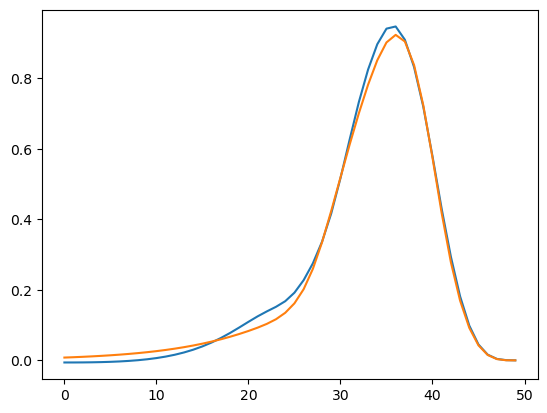

In [40]:
plt.plot(jnp.einsum("i,ijk->jk", get_params(opt_state), INPUT_GRID)[5, :])
plt.plot(INPUT_GRID[0, 5,:])

In [257]:
convolution.FK_FLAVOURS

array(['photon', '\\Sigma', 'g', 'V', 'V3', 'V8', 'V15', 'V24', 'V35',
       'T3', 'T8', 'T15', 'T24', 'T35'], dtype='<U6')

In [216]:
len(chi2_contribs)

73

In [217]:
loss(get_params(opt_state), chi2_contribs)

Array(nan, dtype=float32)

In [ ]:
loss()

In [180]:
ii = iter(batch_stream())

In [16]:


cd = load_commondata(ds.commondata).with_cuts(ds.cuts)

central_value = jnp.array(cd.central_values)

covmat = covmats.covmat_from_systematics(cd, dataset_input=ds)



sqrt_covmat = jnp.array(covmats.sqrt_covmat(covmat))

jnp.sum(jla.solve_triangular(sqrt_covmat, central_value, lower=True)**2)





No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array(43581.004, dtype=float32)

In [191]:
next(ii)

[<PjitFunction of <function make_chi2.<locals>.chi2 at 0x7fa188021940>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badeea160>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9d2d025a60>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9e01c2b790>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9bade95160>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9bade67ca0>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badee85e0>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badef3040>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9d23cdb700>>,
 <PjitFunction of <function make_chi2.<locals>.chi2 at 0x7f9badec5ee0>>]

In [101]:
covmats.systematics_matrix_from_commondata??

In [56]:
a = np.random.rand(len(covmat))

In [67]:
import scipy.linalg as la

In [68]:
a@la.inv(covmat)@a

76949.52986563856

In [98]:
jnp.sum(jla.solve_triangular(sqrt_covmat, a, lower=True)**2)

Array(76949.53, dtype=float32)

In [69]:
from validphys.calcutils import calc_chi2

In [70]:
calc_chi2(la.cholesky(covmat, lower=True), a)

76949.52986563857

In [74]:
calc_chi2(covmats.sqrt_covmat(covmat), a)

76949.52986563857

In [76]:
sm = covmats.systematics_matrix_from_commondata(cd, ds)

In [77]:
sm.shape

(121, 226)

In [80]:
q,r = la.qr(sm)

In [81]:
q

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [86]:
la.solve_triangular(r, a)

ValueError: expected square matrix

In [88]:
import matplotlib.pyplot as plt

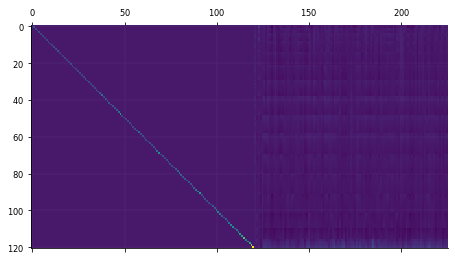

In [90]:
plt.matshow(q@r)

In [66]:
la.cholesky??

In [ ]:
from val

In [48]:
covmat

array([[ 2.68593312e-04,  1.83984561e-04,  7.67906773e-05, ...,
        -7.63211469e-05, -1.05104702e-04, -1.37744623e-04],
       [ 1.83984561e-04,  4.04746250e-04,  6.08510678e-05, ...,
        -1.27447854e-04, -1.71832192e-04, -2.22663390e-04],
       [ 7.67906773e-05,  6.08510678e-05,  1.91100734e-04, ...,
         1.14004879e-04,  1.45105124e-04,  1.87405121e-04],
       ...,
       [-7.63211469e-05, -1.27447854e-04,  1.14004879e-04, ...,
         2.33261176e-03,  1.15595913e-03,  1.43098653e-03],
       [-1.05104702e-04, -1.71832192e-04,  1.45105124e-04, ...,
         1.15595913e-03,  4.07094629e-03,  1.80012082e-03],
       [-1.37744623e-04, -2.22663390e-04,  1.87405121e-04, ...,
         1.43098653e-03,  1.80012082e-03,  6.43026459e-03]])

In [42]:
covmat_from_systematics??

In [23]:
cd.central_values

entry
46     0.9734
47     0.9821
59     0.9716
60     0.9817
61     0.9942
        ...  
256    0.6717
257    0.7194
258    0.6959
259    0.7020
260    0.7724
Name: data, Length: 121, dtype: float64

LHAPDF 6.4.0 loading /home/zah/anaconda3/envs/nnpdfdev/share/LHAPDF/NNPDF40_nlo_as_01180/NNPDF40_nlo_as_01180_0000.dat
NNPDF40_nlo_as_01180 PDF set, member #0, version 1


In [318]:
pdf_base.shape

(14, 50)

In [319]:
vals.shape

(14, 50)

In [320]:
loss(vals, chi2_contribs)

Array(5888.8696, dtype=float32)

In [157]:
def loss(nn):
    return nn - vals

In [158]:
vals.shape

(1, 14, 50)

In [159]:
tb = load_fktable(ds.fkspecs[0])

In [160]:
tb.luminosity_mapping

array([ 1,  1,  1,  2,  1,  3,  1,  4,  1,  5,  1,  6,  1,  9,  1, 10,  1,
       11,  2,  2,  2,  3,  2,  4,  2,  5,  2,  6,  2,  9,  2, 10,  2, 11,
        3,  3,  3,  4,  3,  5,  3,  6,  3,  9,  3, 10,  3, 11,  4,  4,  4,
        5,  4,  6,  4,  9,  4, 10,  4, 11,  5,  5,  5,  6,  5,  9,  5, 10,
        5, 11,  6,  6,  6,  9,  6, 10,  6, 11,  9,  9,  9, 10,  9, 11, 10,
       10, 10, 11, 11, 11])

In [162]:
tb.get_np_fktable().shape

(17, 45, 50, 50)

In [163]:
from jax.example_libraries import stax

In [183]:
init, predict = stax.serial(stax.Dense((2)), stax.Dense((3)))

In [184]:
from jax import random

In [185]:
rng = random.PRNGKey(3)

In [188]:
init(rng, (1,))

((3,),
 [(Array([[-0.99891424,  0.79900575]], dtype=float32),
   Array([0.01032689, 0.01061993], dtype=float32)),
  (Array([[-0.97583795, -0.5411103 , -0.47663605],
          [-1.1263915 , -0.7123102 , -1.2609658 ]], dtype=float32),
   Array([-0.0023886 , -0.00962158,  0.01378133], dtype=float32))])

In [189]:
import numpy as np

In [192]:
initial = np.random.rand(50)

In [193]:
import matplotlib.pyplot as plt

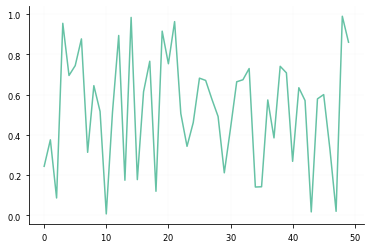

In [194]:
plt.plot(initial)

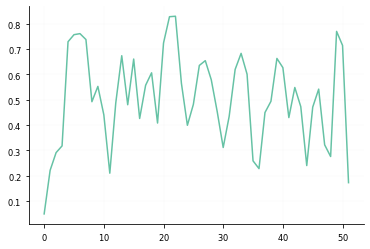

In [197]:
plt.plot(np.convolve(initial, [0.2, 0.6, 0.2]))

In [370]:
from jax.example_libraries import stax

In [373]:
pdf_base.shape

(14, 50)

In [379]:
init, apply = stax.Conv(1, (1,10))

In [380]:
stax.Conv??

In [382]:
init??

In [384]:
init(rng, (14,50,1))

IndexError: tuple index out of range

In [385]:
%debug

> /home/zah/anaconda3/envs/nnpdfdev/lib/python3.9/site-packages/jax/example_libraries/stax.py(76)<listcomp>()
     74     filter_shape_iter = iter(filter_shape)
     75     kernel_shape = [out_chan if c == 'O' else
---> 76                     input_shape[lhs_spec.index('C')] if c == 'I' else
     77                     next(filter_shape_iter) for c in rhs_spec]
     78     output_shape = lax.conv_general_shape_tuple(

ipdb> lhs_spec
'NHWC'
ipdb> q


In [393]:
@jax.jit
def f(obj):
    return obj["inte"]

In [394]:
class X:
    inte = 1

In [395]:
f({"inte":1})

Array(1, dtype=int32, weak_type=True)